<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**This study tries to loop upon each strategy on its own decoding/navigation performance**

**Somethings to study**:
1.  Take the overall statistics of results, compare what is qualitative change between echo state and pretrained network of different eigen values. Slightly better generalization of pretrained net in overall 
2.  Relation of decoding vs performance  Does decoding predicts small size performance?  Does decoding generalization performance? Does the decoding evolving in the q leanring predicts anything?   
3.  Does the eigen values, which are the fingerprint of dynamics, predicts anything?   

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

import Nets
from Nets import*

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Norm summary for different networks 
Try to get all performances 15, 35, 55, 85 here.  

In [2]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(40)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_pre2/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [3]:
np.save('Nhh_pre2', Nhh)
np.save('Nah_pre2', Nah)
np.save('Nih_pre2', Nih)

In [21]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(40)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_pre2_wah/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [22]:
np.save('Nhh_pre2_wah', Nhh)
np.save('Nah_pre2_wah', Nah)
np.save('Nih_pre2_wah', Nih)

In [9]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(40)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [10]:
np.save('Nhh_pre1', Nhh)
np.save('Nah_pre1', Nah)
np.save('Nih_pre1', Nih)

In [29]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(40)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_cpu2/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [30]:
np.save('Nhh_pre1_2', Nhh)
np.save('Nah_pre1_2', Nah)
np.save('Nih_pre1_2', Nih)

In [37]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(20)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_cpu_stim_xy/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [38]:
np.save('Nhh_pre_mix', Nhh)
np.save('Nah_pre_mix', Nah)
np.save('Nih_pre_mix', Nih)

In [51]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(35)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_cpu_xy_noinfo/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [52]:
np.save('Nhh_xy_noinfo', Nhh)
np.save('Nah_xy_noinfo', Nah)
np.save('Nih_xy_noinfo', Nih)

In [9]:
# try to understand the relation between principle component and the eigen vector = attractor here.   principle component should reflect this attractor state？  
nets1 = np.arange(400)
Nhh = []
Nah = []
Nih = []
Nets = [nets1]
for net in range(1):
    nhhs= []
    nahs = []
    nihs = []
    index = Nets[net]
    for trial in index:
#       readout weight as trained
        Net = torch.load('weights_cpu_pos/rnn_1515tanh512_checkpoint{}'.format(trial))
        nhh = torch.norm(Net['h2h']).cpu().data.numpy().copy()
        nah =  torch.norm(Net['a2h']).cpu().data.numpy().copy()
        nih =  torch.norm(Net['i2h']).cpu().data.numpy().copy(0)
        nhhs.append(nhh)
        nahs.append(nah)
        nihs.append(nih)
    Nhh.append(np.array(nhhs))
    Nah.append(np.array(nahs))
    Nih.append(np.array(nihs))

In [10]:
np.save('Nhh_pos', Nhh)
np.save('Nah_pos', Nah)
np.save('Nih_pos', Nih)

# taket the egien values corresponding to selected neurons
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Eigen_img_pre1 = np.load('Eigen_img.npy')
Eigen_real_min_pre1  =  np.load('Eigen_real_min.npy')
Eigen_img_pre2 = np.array(Eigen_img)
Eigen_real_max_pre2 = np.array(Eigen_real_max)
Eigen_real_min_pre2 = np.array(Eigen_real_min)
plt.plot(Eigen_img_pre2[0].ravel(), Eigen_real_min_pre2[0].ravel(), 'r.')
plt.plot(Eigen_img_pre1[0].ravel(), Eigen_real_min_pre1[0].ravel(), 'g.')

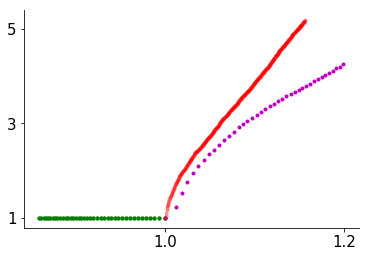

In [12]:
# pretrain2
Nhh = np.load('Nhh_pre2.npy')
Nah = np.load('Nah_pre2.npy')
Nih = np.load('Nih_pre2.npy')
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.figure(0)
plt.plot(np.array(Nhh).ravel()/Nhh[0, 0], np.array(Nah).ravel()/Nah[0, 0], 'g.')
# pretrain1
plt.plot(np.array(Nhh).ravel()/Nhh[0, 0], np.array(Nih).ravel()/Nih[0, 0], 'g.')
Nhh = np.load('Nhh_pre1.npy')
Nah = np.load('Nah_pre1.npy')
Nih = np.load('Nih_pre1.npy')
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.figure(0)
plt.plot(np.array(Nhh).ravel()/Nhh[0, 0], np.array(Nah).ravel()/Nah[0, 0], 'm.')
plt.xticks([0.8, 1, 1.2], size = 15)
plt.yticks([1, 3, 5], size = 15)

Nhh = np.load('Nhh_pos.npy')
Nah = np.load('Nah_pos.npy')
Nih = np.load('Nih_pos.npy')
plt.plot(np.array(Nhh).ravel()/Nhh[0, 0], np.array(Nah).ravel()/Nah[0, 0], 'r.', alpha = 0.3)

### Performance compare 

In [21]:
# Performance_s_early_abs = np.load('performance_s_early_abs.npy')
# Performance_l_early_3 = np.load('performance_l_early_net_3.npy')
Performance_echo_abs = np.load('Performance_echo_position.npy')[0]
Performance_echo_abs.shape

(5, 6)

In [22]:
Performance_exxl = np.concatenate((Performance_exxl_late_1[0], Performance_exxl_late_2[0], Performance_exxl_late_3[0]), axis = 0)
Performance_exl = np.concatenate((Performance_exl_late_1[0], Performance_exl_late_2[0], Performance_exl_late_3[0]), axis = 0)
Performance_l = np.concatenate((Performance_l_late_1[0], Performance_l_late_2[0], Performance_l_late_3[0]), axis = 0)
Performance_m = np.concatenate((Performance_m_late_1[0], Performance_m_late_2[0], Performance_m_late_3[0]), axis = 0)
Performance_s = np.concatenate((Performance_s_late_1[0], Performance_s_late_2[0], Performance_s_late_3[0]), axis = 0)

### Pretrained Net
draw pictures about the echo state and largest training samples performance evolution & generalization   Add path integrator or position network 

longer time, there is no pheonmean associate with multi-stability

Here with action feedback, dynamics shift to a totally different regime which is around hopf bifurcation, but it is not hugely shaped by the stimulus

From this graph of PC, we will see that the representation states of trajectory (3,5) and (14,5) are actually qutie close to each other , reflecting symmetry in real space, it is in spirit of predictive decoding, using least number of interal states to play well. 

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**